## Spark Initializing

In [1]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import seaborn as sns # To get graphs
import matplotlib.pyplot as plt # To get graphs

In [2]:
#### First we have create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .appName('ModelBuild') \
                    .getOrCreate()

In [3]:
spark

## Import Data Set

In [4]:
#df = spark.read.option("header" , True).csv("D:\\Vizuamatix exam\\final_dispatch.csv")
df = spark.read.option("header" , True).csv("/Users/Asus/Documents/InternCsv/combine_final.csv")

In [5]:
df.show(10)

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|     KPS(GT7)|7/1/2020|0:00|              0|                  0|         0|
|         Polp|7/1/2020|0:00|             40|                 78|       -38|
|          WPS|7/1/2020|0:00|              0|                  0|         0|
|         Rand|7/1/2020|0:00|              0|                  0|         0|
|VPOWER Horona|7/1/2020|0:00|              0|                  0|         0|
|       LVPS 2|7/1/2020|0:00|            540|                270|       270|
|          Uku|7/1/2020|0:00|             72|                 40|        32|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|

In [6]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
df_dev = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date","Time","Plant")))

In [7]:
df_dev.show(10)

+-------------+--------+----+---------------+-------------------+----------+--------------------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|                rank|
+-------------+--------+----+---------------+-------------------+----------+--------------------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|                 0.0|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|2.154475923731552...|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|4.308951847463105E-5|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|6.463427771194657E-5|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33| 8.61790369492621E-5|
|        Barge|7/1/2020|0:00|             90|                 45|        45|1.077237961865776...|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|1.292685554238931...|
|CEB Sup Power|7/1/2

In [8]:
train_df = df_dev.where("rank <= .8")
train_df.show()

+-------------+--------+----+---------------+-------------------+----------+--------------------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|                rank|
+-------------+--------+----+---------------+-------------------+----------+--------------------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|                 0.0|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|2.154475923731552...|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|4.308951847463105E-5|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|6.463427771194657E-5|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33| 8.61790369492621E-5|
|        Barge|7/1/2020|0:00|             90|                 45|        45|1.077237961865776...|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|1.292685554238931...|
|CEB Sup Power|7/1/2

In [9]:
train_df = train_df.withColumn("Difference",train_df.Difference.cast('double'))
train_df = train_df.withColumn("Actual_Dispatch",train_df.Actual_Dispatch.cast('double'))
train_df = train_df.withColumn("Forecasted_Dispatch",train_df.Forecasted_Dispatch.cast('double'))

In [10]:
train_df.dtypes

[('Plant', 'string'),
 ('Date', 'string'),
 ('Time', 'string'),
 ('Actual_Dispatch', 'double'),
 ('Forecasted_Dispatch', 'double'),
 ('Difference', 'double'),
 ('rank', 'double')]

In [11]:
from pyspark.sql.functions import col
sumtot = train_df.groupBy("Date").sum("Actual_Dispatch","Forecasted_Dispatch","Difference","rank").sort(col("Date").asc())

In [12]:
sumtot.show(10)

+---------+--------------------+------------------------+---------------+------------------+
|     Date|sum(Actual_Dispatch)|sum(Forecasted_Dispatch)|sum(Difference)|         sum(rank)|
+---------+--------------------+------------------------+---------------+------------------+
| 7/1/2020|            164394.0|                 86666.0|        77728.0| 30.38586663794032|
|7/10/2020|            168756.0|                 84202.0|        84554.0| 94.69283636755364|
|7/11/2020|            150952.0|                 80095.0|        70857.0|153.73909296563616|
|7/12/2020|            133281.0|                 69588.0|        63693.0|221.57044059032634|
|7/13/2020|            163359.0|                 82308.0|        81051.0| 285.9027469568028|
|7/14/2020|            173932.0|                 87793.0|        86139.0| 350.2350533232791|
|7/15/2020|            171561.0|                 87663.0|        83898.0| 414.5673596897554|
|7/16/2020|            165218.0|                 85969.0|        79249

In [13]:
from pyspark.sql.functions import *
newColumns = ["Plant","Actual_Dispatch","Forecasted_Dispatch","DispatchDiff","Rank"]
sumtot=sumtot.toDF(*newColumns)

In [14]:
df1 = sumtot.toPandas()
df1.head()

,Plant,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff,Rank
0,7/1/2020,164394.0,86666.0,77728.0,30.385867
1,7/10/2020,168756.0,84202.0,84554.0,94.692836
2,7/11/2020,150952.0,80095.0,70857.0,153.739093
3,7/12/2020,133281.0,69588.0,63693.0,221.570441
4,7/13/2020,163359.0,82308.0,81051.0,285.902747


## Heatmap For Finding Correlation

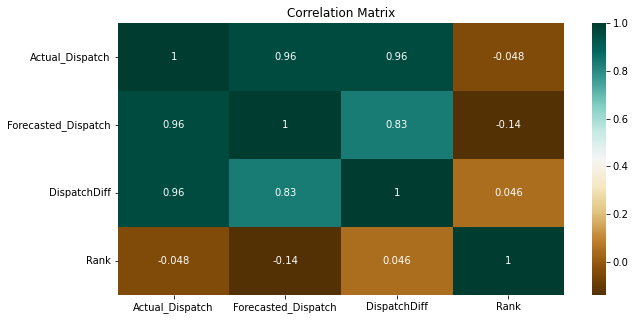

In [15]:
# Correlation Heatmap
plt.figure(figsize = (10, 5))
c = df1.corr()
sns.heatmap(c, cmap = "BrBG", annot = True)
plt.title("Correlation Matrix")
plt.show()

In [16]:
df1.dtypes

Plant                   object
Actual_Dispatch        float64
Forecasted_Dispatch    float64
DispatchDiff           float64
Rank                   float64
dtype: object

In [17]:
from datetime import datetime
from typing import Any, Callable, Dict, Iterable
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer
from sklearn.ensemble import (
    GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import (
    BaseCrossValidator, GridSearchCV, StratifiedKFold, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from seaborn import boxplot, countplot

### Data Visualisation

We introduce a simple class for automating the creation of basic visualisations that are suitable for a binary classification task and which treat continuous and non-continuous features differently.

In [18]:
class VizFeatureBinaryClass:
    """Automate binary classifier feature visualisation."""
    
    def __init__(self, label_col: str, feature_cols: Iterable[str],
                 data: DataFrame) -> None:
        plot_data = data[feature_cols + [label_col]]
        self.plots = {}
        for feature in feature_cols:
            fig, ax = plt.subplots()
            plt.close(fig)
            if plot_data[feature].dtype == 'float64':
                plot = boxplot(x=label_col, y=feature, data=plot_data, ax=ax)
            else:
                plot = countplot(x=feature, hue=label_col, data=plot_data,
                                 ax=ax)
            plot.set_title(feature)
            self.plots[feature] = plot
    
    def show(self, feature: str) -> None:
        """Display single plot."""
        plot = self.plots[feature]
        display(plot.figure)
        return None

    def show_all(self) -> None:
        """Display all plots."""
        for plot in self.plots.values():
            display(plot.figure)
        return None

## Extract Class Labels

The class labels for this classification task are in the Survived column of the training data. We split this column into seperate vector for **model training.**

In [19]:
labels = df1.Actual_Dispatch.values

In [20]:
survived_fraction = labels.sum() / labels.shape[0]
print(f'{survived_fraction} Average Dispacth of the Plants in July')

156885.77272727274 Average Dispacth of the Plants in July


## Spit Dataset into Train and Test Subsets

Use **stratified sampling** to ensure that classes are fairly represented in both train and test data.

In [21]:
x=df1.iloc[:, 1:3].values  
y=df1.iloc[:,4].values

In [22]:
x

array([[164394.,  86666.],
       [168756.,  84202.],
       [150952.,  80095.],
       [133281.,  69588.],
       [163359.,  82308.],
       [173932.,  87793.],
       [171561.,  87663.],
       [165218.,  85969.],
       [165218.,  82911.],
       [159815.,  82847.],
       [140516.,  67697.],
       [161345.,  83312.],
       [150243.,  82204.],
       [159014.,  81733.],
       [168316.,  85996.],
       [161692.,  85618.],
       [155644.,  80132.],
       [152612.,  74585.],
       [139838.,  67123.],
       [171161.,  83587.],
       [173788.,  87930.],
       [100832.,  52798.]])

In [26]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)


## Feature Engineering

In [30]:
from sklearn import tree
import graphviz 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

## Fitting to the Model

In [31]:
from sklearn.ensemble import RandomForestClassifier
randf=RandomForestRegressor(n_estimators=900)
randf.fit(X_train,y_train)
y_pred=randf.predict(X_test)

In [33]:
randf.feature_importances_

array([0.50512398, 0.49487602])

In [35]:
ylables=['Actual Dispatch','Forecasted_Dispatch']

<BarContainer object of 2 artists>

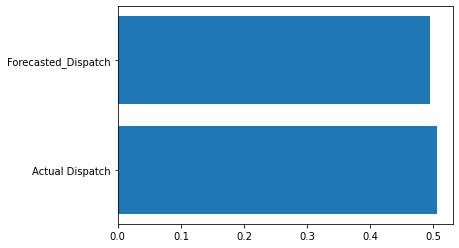

In [37]:
plt.barh(ylables, randf.feature_importances_)

#### Actual Dispatch is Recognized as the Most Features Component

In [48]:
features = df1.columns.values.tolist()[1:3]
feature_pro = pd.Series(randf.feature_importances_,index=features).sort_values(ascending=False)

In [45]:
feature_pro

Actual_Dispatch        0.505124
Forecasted_Dispatch    0.494876
dtype: float64

In [50]:
df1['Actual_Dispatch'].describe()

count        22.000000
mean     156885.772727
std       16785.946988
min      100832.000000
25%      151367.000000
50%      161518.500000
75%      167541.500000
max      173932.000000
Name: Actual_Dispatch, dtype: float64

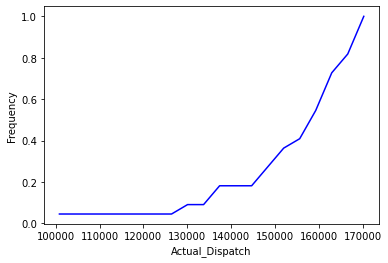

In [51]:
values, base = np.histogram(df1['Actual_Dispatch'], bins=20)
Accumalate = np.cumsum(values/df1.shape[0])
plt.plot(base[:-1], Accumalate, c='blue')
plt.xlabel('Actual_Dispatch')
plt.ylabel('Frequency')
plt.show()

Since the median **"Actual Dispatch"** is **161518** and **mean Dispatch is ∼157000**, we classify Plants as **'Semi-Prioritized Plants'** if Actual_Dispacth is less then or equal to **162,000** , otherwise we classify the Plants as **'Prioritized Plants'**. We repleace the column **"Actual Dispatch"**  with the value 0 for '**Semi-Prioritized**' Plants and the value 1 for '**Prioritized**' Plants.

In [56]:
indeksDaarlig = df1.loc[df1['Actual_Dispatch'] <= 162000].index
indeksGod = df1.loc[df1['Actual_Dispatch'] > 162000].index
df1.iloc[indeksDaarlig, df1.columns.get_loc('Actual_Dispatch')] = 0
df1.iloc[indeksGod, df1.columns.get_loc('Actual_Dispatch')] = 1

In [57]:
df1['Actual_Dispatch'].value_counts()

0.0    12
1.0    10
Name: Actual_Dispatch, dtype: int64

## Decision Tree

In [60]:
final=df1.select_dtypes('float64')

In [61]:
final.head(10)

,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff,Rank
0,1.0,86666.0,77728.0,30.385867
1,1.0,84202.0,84554.0,94.692836
2,0.0,80095.0,70857.0,153.739093
3,0.0,69588.0,63693.0,221.570441
4,1.0,82308.0,81051.0,285.902747
5,1.0,87793.0,86139.0,350.235053
6,1.0,87663.0,83898.0,414.567360
7,1.0,85969.0,79249.0,478.899666
8,1.0,82911.0,82307.0,543.231972
9,0.0,82847.0,76968.0,607.564279


## Decision Model

In [63]:
x = final.iloc[:,1:]
y = final['Actual_Dispatch']

In [64]:
#Choosing 40% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.40, random_state = 42)

In [69]:
# Making a decision tree with two levels.
clfTre = tree.DecisionTreeClassifier(max_depth=3)
clfTre.fit(xTrain, yTrain)

DecisionTreeClassifier(max_depth=3)

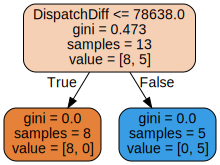

In [70]:
#Visualizing the decision tree
dot_data = tree.export_graphviz(clfTre, out_file=None, max_depth=3, feature_names=list(x.columns.values), filled=True, rounded=True)
valgTre = graphviz.Source(dot_data) 
valgTre

We observe that our model uses the all levels of Features in Wine to first to make a decision. Also, note that based on **Actual Dispatch** level if the the Dispatch_Diff is **lower than 78600**, then the wine is most likely **'Prioritzed Plant'**. On the other hand, is the **DispacthDiff >= 78600**  then the Plant is most likely **'Semi-Prioritized Plant'**.

In [71]:
utfall = (clfTre.predict(xTest) == yTest).value_counts()
print("The Decision Tree predicts the test data in", (utfall[1]/(utfall[0]+utfall[1]))*100 , "% of the cases.")

The Decision Tree predicts the test data in 88.88888888888889 % of the cases.


## Usage Of Random Forest

In [72]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(xTrain, yTrain)

RandomForestClassifier(max_depth=10, random_state=0)

In [73]:
utfall = (rf.predict(xTest) == yTest).value_counts()
print("The Decision tree Predicts the test data in", (utfall[1]/(utfall[0]+utfall[1]))*100 , "% of the cases.")

The Decision tree Predicts the test data in 88.88888888888889 % of the cases.


Both of the Methods Provide Same Accuray due to the **Small-sized Data Set** is Used.